# A normal distribution sampler in python

Last year, I had the pleasure of attending a tutorial with the great [Petros Dellaportas](http://www.homepages.ucl.ac.uk/~ucakpde/#), a one-day primer in bayesian inference. One of the main sessions was about Markov chain Monte Carlo sampling, the technique whose name inspired one of the all-time greatest blog names (and blogs) ever: ['While my MCMC gently samples'](https://twiecki.io/)... and _also_ a game-changing statistical insight when it comes to sampling from complex statistical distributions. Following the session, I caught up with Petros and asked a dumb but useful question: 

<p><center>'So, I kind of understand MCMC now... but why does it matter?!'</center></p>

Petros being Petros, he was more than equal to my question:

<p><center>'MCMC is a tool to sample from complex distributions. Let's start with a simple distribution, the Normal Distribution. After this session, go and write a normal distribution sampler. Then, go and look up the Box-Mueller method, and you'll realise that MCMC matters - effective sampling from distributions is not trivial!'</center></p>

So, here's my naive attempt at sampling from the normal distribution:
- Use trapezia to approximate the area under normal distribution curve
- The size of the strip can tell us how many uniformly distributed samples we need for that range
- We can get a better approximation with more strips

In [9]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
%matplotlib inline 


The probability density function of the normal distribution is defined as:

$$ f(x|\mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma ^2}}e ^ {- \frac{(x-\mu)^2}{2\sigma^2}}  $$

In [23]:
from math import pi

def norm(x_array, m, s):
    point_array = 1/np.sqrt(2* pi * s ** 2) * np.exp((-(x_array - mu)**2)/2*s**2)
    return(point_array)

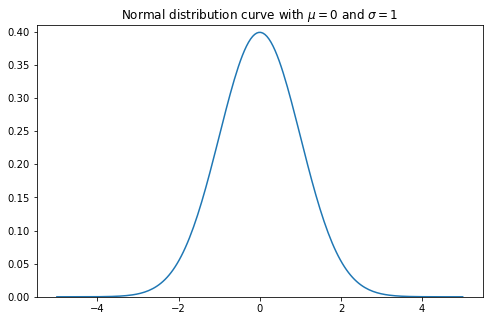

In [32]:
mu = 0
sigma = 1
x = np.linspace(-5,5,200)
y = norm(x, m=0, s=1)


fig, ax = plt.subplots(figsize=(8,5))

ax.set_ylim([0,0.41])

ax.plot(x, y)
plt.title("Normal distribution curve with $\mu=${} and $\sigma=${}".format(mu,sigma))
plt.show()

Now, if we want to use the uniform sampler to generate a sample distribution X, such that $ X \sim N(0, 1)$, we need to know how to reshape our uniform distribution. To do this, we'll split the normal curve into strips, calculate the area under the curve for each strip, and use this to tell us how many uniformly distributed samples we need for each strip. 


Given an interval, we can calculate the y values at the beginning and end of the interval, then we use the trapezium rule to get the area of this slice:

$$ \frac{1}{2} * (a + b) * width $$  



In [34]:
## function to calculate the trapezium area

def trap_area(y1, y2, width):
    return 0.5*(y1 + y2)* width

trap_area(*y_vals, x_width)

0.09820129965053524

In [638]:
sigma = 1
mu = 0
n_sigma = 4

## set our full interval to be 4 s.d. from the mean
## so with X~(0,1) we'll get an interval of (-4, 4)

interval = np.array([mu - sigma * n_sigma,mu + sigma * n_sigma])

## split this into k strips, which will control how fine-grain our slices are (let's say k = 80, intervals of 0.1)
k = 100

strip_width = (interval[1]-interval[0])/k
sub_strips = np.linspace(*interval, k + 1) ## 81 edges gives 80 strips
sub_strips_pairs = [np.array([sub_strips[p],sub_strips[p+1]]) for p in range(k)]


## also set how many samples we want 
n = 10000

## the area of the strip tells us how many values we want to select, as a proportion of n
## create an array of areas

areas = np.array([trap_area(*norm(s, mu, sigma), strip_width) for s in sub_strips_pairs])

print(areas.sum()) ## Check that my probabilities summed to 1. They don't quite, because the trapezium rule is an estimate.
                   ## We'll need a way to make sure this discrepancy doesn't affect the number of samples we want to produce at the end

0.99993608729814


In [692]:
%%timeit
n = 100000
samples = []
for i in range(n):
    rand__ = np.random.random() * strip_width
    interval = np.random.multinomial(1, areas).argmax()
    sample = np.array(sub_strips)[interval] + rand__
    samples.append(sample)

2.04 s ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


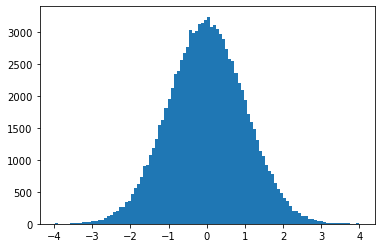

In [640]:
plt.hist(samples, bins=100)
plt.show()

This approach is simple enough, but it's only an estimate, and the better the estimate, the longer it will take to run. Thankfully, there's a bunch of better techniques already developed which can help!

## The Box-Mueller implementation

The Box-Mueller transform is one of the first, and is really neat in terms of it's simplicity, transforming a random cartesian coordinate to polar coordinates and leveraging the link between polar coordinates and the gaussian function.

See [here](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform#cite_note-5) for a summary, and [here](https://math.stackexchange.com/a/3334295/448595) for a nice intuitive explanation.

https://upload.wikimedia.org/wikipedia/commons/1/1f/Box-Muller_transform_visualisation.svg

In [774]:
n = 100000
y1 = np.random.random(n)
y2 = np.random.random(n)
x1 = np.sqrt(-2 * np.log(y1)) * np.cos(2 * np.pi * y2)

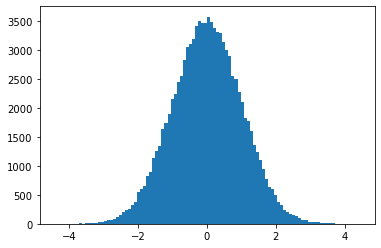

In [777]:
plt.hist(x1, bins=100)
plt.show()

### Marsaglia polar method

At the time, the Marsaglia polar method was more efficient than box-mueller -- using a square root and a log instead of a cosine function, which would be more expensive, at least on older processors (these days it may not be!)

In [270]:
def reject_r2():
    r2 = 1
    while r2 >= 1:
        y1 = np.random.random() * 2 - 1
        y2 = np.random.random() * 2 - 1
        r2 = y1 ** 2 + y2 ** 2
    return r2, y1, y2

def transform_r2(r2):
    return np.sqrt( -2 * np.log(r2) / r2)   

In [689]:
n = 100000

x1s = []
x2s = []

for i in range(n):    
    r2, y1, y2 = reject_r2()
    transformed_r2 = transform_r2(r2)

    x1 = transformed_r2  * y1
#     x2 = transformed_r2 * y2
    
    x1s.append(x1)
#     x2s.append(x2)

635 ms ± 9.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


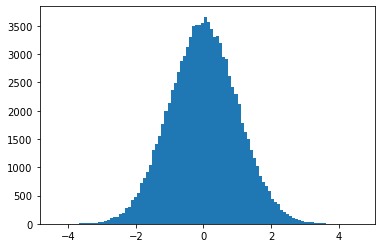

In [526]:
plt.hist(x1s, bins=100)
plt.show()

### Marsaglia's Ziggurat

This one is my favourite, mainly because of the cool pyramid shape that you get. However, it's a bit more tricky to implement. Essentially, we split the distribution into a series of rectangles, with an end section following the curve of the distribution. Then for each uniform random number we generate, we can test whether the number is within the distribution, and since most of them will be within a rectangle, we don't need _any_ complex (and hence costly) calculations.

In [52]:
from scipy.special import erf, erfc

def gauss(x):
    return np.exp((- x ** 2) / 2)


def inverse_gauss(x):
    return np.sqrt(- 2 * np.log(x))

def unnormalised_erfc(x):
    return np.sqrt(np.pi / 2) * erfc(x / np.sqrt(2))


The key to this algorithm is that each rectangular layer has the same area as the unbounded base layer, so given a specific number of layers, we must determine what this area is. To do so, we use an optimisation function to minimise the height of each rectangle.

In [709]:
from scipy.optimize import bisect

n = 5

def find_x1(x, n):
    y = gauss(x)
    area = unnormalised_erfc(x) + x * y
    for i in range(n):
        y_new = y + area / x
        x_new = inverse_gauss(y_new)
        y = y_new
        x = x_new
    if np.isnan(y):
        return -1
    else:
        return 1 - y

x_1 = bisect(lambda x:find_x1(x, n), 1, 5)
print(x_1)

2.1760594405477605


<ipython-input-52-7d7d6863c5ec>:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(- 2 * np.log(x))


Now we can calculate the x values for each subsequent layer, as well as an $x_0$ value which we will use to test values in the base layer.

In [644]:
def calculate_table(x, n):
    y = gauss(x)
    areas = []
    xs = []
    ys = []
    area = unnormalised_erfc(x) + x * y
    xs.append(area/y) # this is the test value for the base layer
    for i in range(n):
        areas.append(area)
        y_new = y + area / x
        x_new = inverse_gauss(y_new)
        xs.append(x)
        ys.append(y)
        area = x * (y_new - y)
        y = y_new
        x = x_new
    xs.append(0)
    return areas, ys, xs

In [710]:
areas, ys, xs = calculate_table(x_1, 5)

<ipython-input-52-7d7d6863c5ec>:8: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(- 2 * np.log(x))


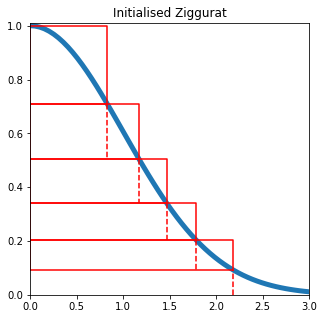

In [771]:
def plot_ziggurat(x, yl, yu):
    ax.plot([0, x, x, 0, 0],[yl, yl, yu, yu, yl], color='r')
    
x = np.linspace(0,3,60)
y = gauss(x)
xs_ = xs[1:-1]
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x, y, linewidth=5)
ax.set_xlim(0,3)
ax.set_ylim(0,1.01)

plot_ziggurat(xs_[-1], ys[-1],1)
ax.plot([xs_[0], xs_[0]],[0, ys[0]], "--",  color='r')
for i in range(1, len(xs_)):
    ax.plot([xs_[i], xs_[i]],[ys[i], ys[i - 1]], "--",  color='r')
    plot_ziggurat(xs[i], ys[i -1],ys[i])

plt.title('Initialised Ziggurat')
plt.show()

The rejection algorithm is as follows:

Select a layer at random, with probability $\frac{1}{n}$. The rightmost boundary of this layer is $x_i$.

Draw two random numbers $0 < u_1, u_2 < 1$

Let $z = u_0 x_i$:

If $z \leq x_{i + 1}$: x is clearly within the distribution, so return z

Else if $u_1(f(x_{i + 1} - f(x_i)) \geq f(z) - f(x_i)$, return $z$, otherwise restart the algorithm.

In the top layer, we will always test $u_1(f(x_{i + 1} - f(x_i)) \geq f(z) - f(x_i)$, since $x_{i + 1} = 0$

In the base layer, we instead test $\frac{uV}{f(x_1)} \geq z$, where V is the area of the base layer, and otherwise use the [marsaglia tail method](https://core.ac.uk/download/pdf/6287927.pdf) to generate a sample.



In [647]:
def marsaglia_tail(s):
    u = np.random.random()
    x = np.sqrt(s ** 2 - 2 * np.log(u))
    while u >= x:
        u = np.random.random()
        x = np.sqrt(s ** 2 - 2 * np.log(u))
    return x


def ziggurat_sample(table):
    # draw a random uniform
    gauss_table = [gauss(x) for x in table]
    i = np.random.randint(0, len(table) - 1)
    u0, u1 = np.random.random(2)
    z = u0 * table[i]
    
    if z < table[i + 1]:
        return z, i, 'box'
    
    elif i >= 1:
        lhs = u1 * (gauss_table[i + 1] - gauss_table[i])
        rhs = gauss(z) - gauss_table[i]
        if lhs < rhs:
            return z, i, 'tail'
        else:
            return ziggurat_sample(table)
    else:
        tail = marsaglia_tail(table[1])
        return tail, i, 'tail'
            
        

In [772]:
%%time 
samples = []
boundaries = []
classes =[]
for i in range(100000):
    sample, i, cls = ziggurat_sample(xs)
    samples.append(sample)
samples = np.array(samples)

Wall time: 3.12 s


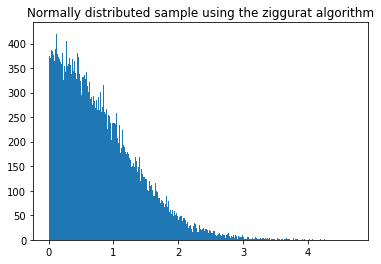

In [773]:
plt.hist(samples, bins=1000)

plt.title('Normally distributed sample using the ziggurat algorithm')
plt.show()